# Optimización Bayesiana de hiperparámetros para modelos de Machine Learning 

https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

**Teoría de la Optimización Bayesiana**
La Optimización Bayesiana es una técnica que utiliza un modelo probabilístico para encontrar el mínimo o máximo de una función objetivo que es costosa de evaluar. En este caso, optimizaremos los hiperparámetros del modelo de Ridge Regression para minimizar el error cuadrático medio (MSE).

**Elementos principales:**

**Espacio de búsqueda:** Define el rango de valores de los hiperparámetros. Por ejemplo, alpha para Ridge Regression.
**Modelo de reemplazo (surrogate):** Una función probabilística (generalmente un Gaussian Process) que modela la función objetivo y predice el rendimiento.
**Función de adquisición:** Selecciona el siguiente conjunto de hiperparámetros a probar, balanceando exploración (buscar áreas desconocidas) y explotación (refinar áreas prometedoras).


**Problema**: Predicción de precios de vivienda en California

Queremos optimizar el hiperparámetro `alpha` del modelo de Ridge Regression para predecir precios de vivienda basándonos en características como ingresos promedio, edad de las viviendas y número promedio de habitaciones.

### Modelaje matemático

El modelo se basa en la regresión lineal regularizada:

$$
\hat{y} = X \beta + \epsilon
$$

donde:

- **$X$** son las características del dataset.
- **$\beta$** son los coeficientes del modelo.
- **$\epsilon$** es el error aleatorio.

La función de pérdida incluye un término de regularización:

$$
\mathcal{L}(\beta, \alpha) = \| y - X \beta \|_2^2 + \alpha \| \beta \|_2^2
$$

donde $\alpha > 0$ controla la regularización.


**Función de pérdida en Ridge Regression**

Ridge Regression modifica la función de pérdida añadiendo un término de regularización $L_2$ que penaliza los coeficientes grandes:

$$
\mathcal{L}(\beta, \alpha) = \| y - X\beta \|_2^2 + \alpha \| \beta \|_2^2
$$

1. **Error de ajuste ($\| y - X\beta \|_2^2$):**
   - Mide qué tan bien el modelo se ajusta a los datos, minimizando la diferencia entre las predicciones $\hat{y}$ y los valores reales $y$.

2. **Regularización ($\alpha \| \beta \|_2^2$):**
   - Penaliza el tamaño de los coeficientes $\beta$. Cuanto más grandes sean, mayor será la penalización.
   - El hiperparámetro $\alpha$ controla la fuerza de esta penalización:
     - Si $\alpha = 0$: El modelo se convierte en una regresión lineal estándar.
     - Si $\alpha$ es muy grande: La penalización domina y los coeficientes $\beta$ se reducen, lo que puede llevar a un modelo subajustado (*underfitting*).

**Propósito de la regularización:**
- Evitar que los coeficientes crezcan descontroladamente, especialmente en presencia de multicolinealidad o muchas variables irrelevantes.
- Mejorar la **generalización** del modelo, es decir, su capacidad para funcionar bien con datos nuevos.


In [1]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from skopt import BayesSearchCV


In [2]:
# Cargar dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Convertir a DataFrame (opcional para análisis exploratorio)
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# Mostrar las primeras filas
print(df.head())  # Visualizar datos

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  target  
0    -122.23   4.526  
1    -122.22   3.585  
2    -122.24   3.521  
3    -122.25   3.413  
4    -122.25   3.422  


In [ ]:
df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'target'],
      dtype='object')

In [ ]:
from sklearn.linear_model import Ridge
# Definir el modelo base
ridge = Ridge()

In [6]:
from skopt import BayesSearchCV

# Espacio de búsqueda para el hiperparámetro alpha
search_space = {
    'alpha': (1e-3, 1e+3, 'log-uniform')  # Rango en escala logarítmica
}

# Configuración de BayesSearchCV
opt = BayesSearchCV(
    estimator=ridge,              # Modelo base
    search_spaces=search_space,   # Espacio de búsqueda
    n_iter=30,                    # Número de iteraciones
    cv=5,                         # Validación cruzada
    scoring='neg_mean_squared_error',  # Métrica
    n_jobs=-1                     # Paralelización
)


In [7]:
# Entrenar la optimización
opt.fit(X, y)

# Resultados de la optimización
print("Mejor valor de alpha:", opt.best_params_['alpha'])
print("Mejor puntuación (MSE negativo):", opt.best_score_)


Mejor valor de alpha: 68.43854218739399
Mejor puntuación (MSE negativo): -0.5579299076270191


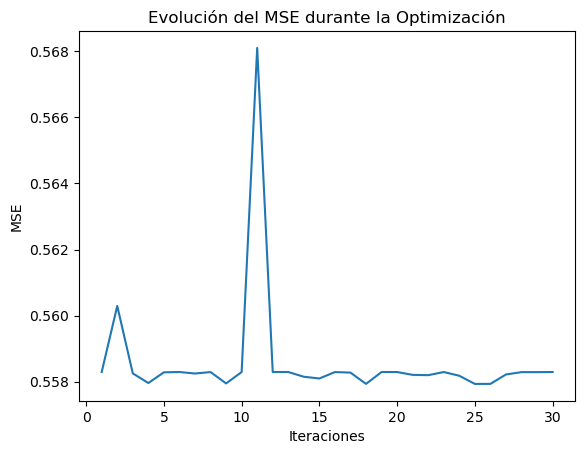

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener resultados
scores = opt.cv_results_['mean_test_score']
iterations = np.arange(1, len(scores) + 1)

# Graficar la evolución del MSE
plt.plot(iterations, -scores)  # Convertir MSE negativo a positivo
plt.xlabel('Iteraciones')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante la Optimización')
plt.show()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo con alpha predeterminado
ridge_default = Ridge(alpha=1.0)
ridge_default.fit(X_train, y_train)
y_pred_default = ridge_default.predict(X_test)
mse_default = mean_squared_error(y_test, y_pred_default)

# Modelo con alpha optimizado
ridge_optimized = Ridge(alpha=opt.best_params_['alpha'])
ridge_optimized.fit(X_train, y_train)
y_pred_optimized = ridge_optimized.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)

print("MSE (Default alpha):", mse_default)
print("MSE (Optimized alpha):", mse_optimized)


MSE (Default alpha): 0.5558034669932188
MSE (Optimized alpha): 0.5511748218415784


Mejor valor de alpha: 70.1893920135676
Mejor puntuación (MSE negativo): -0.5579295858521088


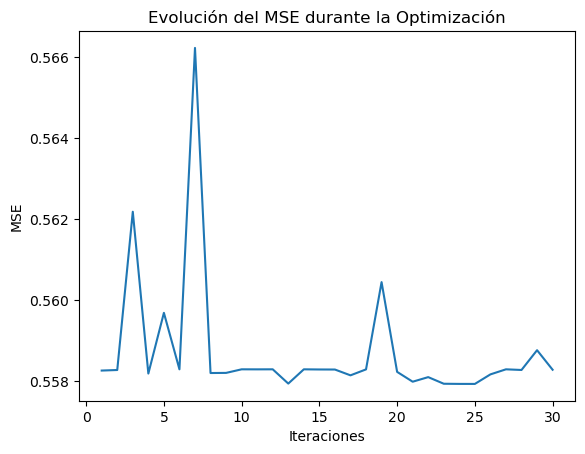

MSE (Default alpha): 0.5558034669932195
MSE (Optimized alpha): 0.5510827750697944


In [4]:
import pandas as pd
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
import matplotlib.pyplot as plt

# Cargar dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Convertir a DataFrame para análisis exploratorio
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

# Definir el modelo base
ridge = Ridge()

# Espacio de búsqueda para el hiperparámetro alpha
search_space = {
    'alpha': (1e-3, 1e+3, 'log-uniform')  # Rango en escala logarítmica
}

# Configuración de BayesSearchCV
opt = BayesSearchCV(
    estimator=ridge,              # Modelo base
    search_spaces=search_space,   # Espacio de búsqueda
    n_iter=30,                    # Número de iteraciones
    cv=5,                         # Validación cruzada
    scoring='neg_mean_squared_error',  # Métrica
    n_jobs=-1                     # Paralelización
)

# Entrenar la optimización
opt.fit(X, y)

# Resultados de la optimización
print("Mejor valor de alpha:", opt.best_params_['alpha'])
print("Mejor puntuación (MSE negativo):", opt.best_score_)

# Graficar la evolución del MSE
scores = opt.cv_results_['mean_test_score']
iterations = np.arange(1, len(scores) + 1)
plt.plot(iterations, -scores)  # Convertir MSE negativo a positivo
plt.xlabel('Iteraciones')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante la Optimización')
plt.show()

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo con alpha predeterminado
ridge_default = Ridge(alpha=1.0)
ridge_default.fit(X_train, y_train)
y_pred_default = ridge_default.predict(X_test)
mse_default = mean_squared_error(y_test, y_pred_default)

# Modelo con alpha optimizado
ridge_optimized = Ridge(alpha=opt.best_params_['alpha'])
ridge_optimized.fit(X_train, y_train)
y_pred_optimized = ridge_optimized.predict(X_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)

print("MSE (Default alpha):", mse_default)
print("MSE (Optimized alpha):", mse_optimized)


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import cross_val_score
from skopt.space import Real,Integer 
from skopt.utils import use_named_args
from skopt import gp_minimize 
from skopt.plots import plot_convergence

housing = fetch_california_housing()
X, y = housing.data, data.target
n_features = X.shape[1]

#gradient boosted trees tend to do well on problems like this 
reg = GradientBoostingRegressor(n_estimators = 50, random_state = 0)

#The list of hyper-parameters we want to optimize. For each one we define the #bounds, the corresponding scikit-learn parameter name, as well as how to 
#samplevalues from that dimension ('log-uniform' for the learning rate) 
space =[Integer(1,5, name = 'max_depth'),  
        Real(10**-5,10**0, "log-uniform", name ='learning_rate'), 
        Integer(1, n_features, name = 'max_features'), 
        Integer(2 ,1000, name = 'min_samples_split'), 
        Integer(1 ,1000, name = 'min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as 
# key word arguments. This is particularly convenient when you want to set 
# scikit-learn estimator parameters 
@use_named_args(space) 
def objective(**params):
        reg.set_params(**params)
        return - np.mean(cross_val_score(reg , X, y, cv = 5, n_jobs = -1, scoring = "neg_mean_absolute_error"))

res_gp = gp_minimize(objective,
                     space,
                     n_calls=50,
                     random_state=0) 

"Best score=%.4f" % res_gp.fun


'Best score=0.4493'

In [7]:
print("""Best parameters:
      - max_depth=%d
      - learning_rate=%.6f
      - max_features=%d
      - min_samples_split=%d
      - min_samples_leaf=%d
      """ % (res_gp.x[0], 
             res_gp.x[1], 
             res_gp.x[2], 
             res_gp.x[3], 
             res_gp.x[4]))

Best parameters:
      - max_depth=5
      - learning_rate=0.231635
      - max_features=4
      - min_samples_split=100
      - min_samples_leaf=100
      


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

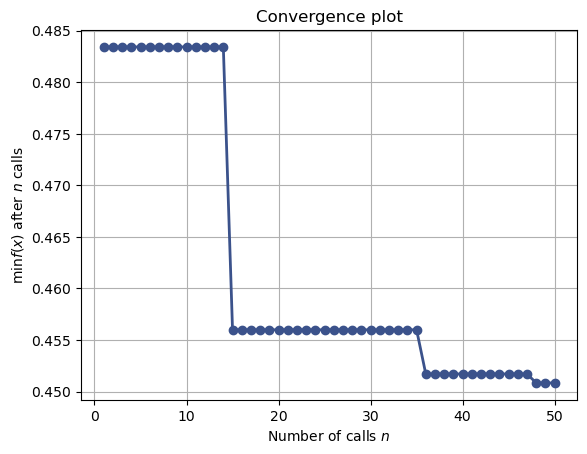

In [8]:
plot_convergence(res_gp)